### Data Preparation and Feature Engineering

This script performs essential data preparation steps on the insurance dataset, including handling missing values and engineering new features. The process includes:

1. **Loading the Dataset**: The dataset is imported using Pandas.
2. **Handling Missing Data**: Numerical columns are imputed with the median, while categorical columns are filled with the mode. Rows with excessive missing data (over 70%) are removed.
3. **Feature Engineering**:
   - Calculation of car age.
   - Insured value per year.
   - Claims frequency.
   - Client risk profile based on personal information.
   - Vehicle risk score based on vehicle characteristics.

The processed data is then saved to a new CSV file.


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
# Load the dataset
df = pd.read_csv('/content/dataset.csv')

# Handling Missing Data
# Numerical columns - Impute with median
numerical_cols = ['SumInsured', 'TotalPremium', 'cubiccapacity']
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

# Categorical columns - Impute with mode
categorical_cols = ['MaritalStatus', 'Gender', 'Citizenship', 'LegalType']
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# Remove rows with excessive missing data (threshold 70%)
df = df.dropna(thresh=int(0.7*df.shape[1]), axis=0)

# Feature Engineering

# 1. Age of Car (CarAge)
df['TransactionDate'] = pd.to_datetime(df['TransactionMonth'])  # Convert to datetime
df['CarAge'] = df['TransactionDate'].dt.year - df['RegistrationYear']

# 2. Insured Value per Year (InsuredPerYear)
df['InsuredPerYear'] = df['SumInsured'] / df['CarAge'].replace(0, 1)  # Avoid division by zero

# 3. Claims Frequency (ClaimsPerYear)
df['ClaimsPerYear'] = df['TotalClaims'] / df['CarAge'].replace(0, 1)

# 4. Client Risk Profile based on client info
df['ClientRiskScore'] = np.where(df['IsVATRegistered'] == 'Yes', 1, 0)
df['ClientRiskScore'] += np.where(df['MaritalStatus'] == 'Single', 1, 0)
df['ClientRiskScore'] += np.where(df['Citizenship'] == 'South Africa', 0, 1)  # Higher risk if not South African

# 5. Vehicle Risk Score based on car info
df['VehicleRiskScore'] = np.where(df['VehicleType'] == 'Passenger Vehicle', 1, 0)
df['VehicleRiskScore'] += df['Cylinders'] / df['Cylinders'].max()  # Normalize cylinder count as risk factor

# Save the processed data
df.to_csv('processed_insurance_data.csv', index=False)

print("Data preparation and feature engineering complete.")

Data preparation and feature engineering complete.


### Categorical Data Encoding

This script focuses on encoding categorical variables in the processed insurance dataset to prepare it for machine learning models. The key steps include:

1. **Loading the Processed Dataset**: The cleaned data is loaded from a CSV file.
2. **One-Hot Encoding**: High-cardinality categorical columns are transformed using one-hot encoding. This avoids excessive dummy variables by dropping the first category.
3. **Label Encoding**: Binary and ordinal categorical columns are encoded using label encoding for simplicity.

The fully encoded dataset is then saved to a new CSV file for further analysis or modeling.


In [5]:
# Load the processed dataset
df = pd.read_csv('/content/processed_insurance_data.csv')

# One-hot encoding for categorical columns with many categories
# This avoids creating too many dummy variables for high-cardinality features.
one_hot_cols = ['Province', 'MainCrestaZone', 'SubCrestaZone', 'VehicleType', 'make', 'Model', 'bodytype']

df = pd.get_dummies(df, columns=one_hot_cols, drop_first=True)

# Label encoding for binary or ordinal categorical columns
label_cols = ['Gender', 'MaritalStatus', 'IsVATRegistered', 'AlarmImmobiliser', 'TrackingDevice', 'NewVehicle', 'WrittenOff', 'Rebuilt', 'Converted', 'CrossBorder']

# Initialize label encoder
label_encoder = LabelEncoder()

# Apply label encoding
for col in label_cols:
    df[col] = label_encoder.fit_transform(df[col].astype(str))

# Save the fully encoded dataset
df.to_csv('encoded_insurance_data.csv', index=False)

print("Categorical data encoding complete.")

Categorical data encoding complete.


### Train-Test Split

This script prepares the encoded insurance dataset for model training by splitting it into training and testing sets. The steps include:

1. **Loading the Encoded Dataset**: The dataset is imported from a CSV file.
2. **Defining Features and Target Variable**: The features (X) are selected by dropping the target variable ('TotalPremium') and the response variable (y) is defined as 'TotalPremium'.
3. **Performing Train-Test Split**: The dataset is split into training (80%) and testing (20%) sets using a random state for reproducibility.
4. **Saving Train and Test Sets**: Optionally, the training and testing datasets are saved to separate CSV files for future use.

This prepares the data for machine learning model training and evaluation.

In [6]:
from sklearn.model_selection import train_test_split

# Load the encoded dataset
df = pd.read_csv('encoded_insurance_data.csv')

# Define your target variable and features
X = df.drop(columns=['TotalPremium', 'TotalClaims'])  # Features
y = df['TotalPremium']  # Target variable (adjust as necessary)

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Save the train and test sets to CSV (optional)
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

print("Train-test split complete.")

Train-test split complete.


### Data Preparation for Regression Models

This script prepares the encoded insurance dataset for regression analysis. The main steps are as follows:

1. **Loading the Dataset**: The dataset is loaded from a CSV file.
2. **Date Processing**: The 'TransactionDate' column is converted to datetime format, and relevant features (year, month, day) are extracted.
3. **Dropping Unused Columns**: The original 'TransactionDate' column is removed if no longer needed.
4. **Defining Features and Target Variable**: Features (X) are selected by excluding 'TotalPremium' and 'TotalClaims', while 'TotalPremium' is defined as the target variable (y).
5. **Checking for Non-Numeric Columns**: A check is performed to identify any non-numeric columns in the feature set.
6. **Handling Missing Values**: Empty strings are replaced with NaN, and missing values are filled with 0 (alternative methods can be used, such as mean or median).
7. **Ensuring Numeric Features**: The data types of the features are printed to confirm they are numeric.

This sets the stage for training regression models.


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset
df = pd.read_csv('encoded_insurance_data.csv')

# Convert date columns to datetime format (assuming 'TransactionDate' is the date column)
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

# Extract relevant features from the date
df['TransactionYear'] = df['TransactionDate'].dt.year
df['TransactionMonth'] = df['TransactionDate'].dt.month
df['TransactionDay'] = df['TransactionDate'].dt.day

# Drop the original date column if it's no longer needed
df.drop(columns=['TransactionDate'], inplace=True)

# Define your target variable and features
X = df.drop(columns=['TotalPremium', 'TotalClaims'])  # Features
y = df['TotalPremium']  # Target variable

# Step 1: Check for non-numeric columns
non_numeric_columns = X.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_columns)

# Step 2: Replace empty strings or spaces with NaN
X.replace(r'^\s*$', pd.NA, regex=True, inplace=True)

# Step 3: Handle missing values (you can drop or fill them)
X.fillna(0, inplace=True)  # Filling missing values with 0 (you can use mean/median if preferred)

# Step 4: Ensure all features are numeric
print(X.dtypes)

Non-numeric columns: Index(['Citizenship', 'LegalType', 'Title', 'Language', 'Bank', 'AccountType',
       'Country', 'ItemType', 'VehicleIntroDate', 'TermFrequency',
       'ExcessSelected', 'CoverCategory', 'CoverType', 'CoverGroup', 'Section',
       'Product', 'StatutoryClass', 'StatutoryRiskType'],
      dtype='object')
UnderwrittenCoverID    int64
PolicyID               int64
TransactionMonth       int32
IsVATRegistered        int64
Citizenship            int64
                       ...  
bodytype_S/D            bool
bodytype_S/W            bool
bodytype_SUV            bool
TransactionYear        int32
TransactionDay         int32
Length: 148, dtype: object


### Regression Model Training and Evaluation

This script trains and evaluates regression models on the encoded insurance dataset. The key steps are as follows:

1. **Loading the Dataset**: The dataset is imported from a CSV file.
2. **Date Processing**: The 'TransactionDate' column is converted to datetime format, and relevant features (year, month, day) are extracted.
3. **Dropping Unused Columns**: The original 'TransactionDate' column is removed if it is no longer needed.
4. **Identifying Categorical Columns**: The script identifies categorical columns in the dataset.
5. **One-Hot Encoding**: Categorical columns are converted to numeric format using one-hot encoding to facilitate model training.
6. **Defining Features and Target Variable**: Features (X) are selected by excluding 'TotalPremium' and 'TotalClaims', while 'TotalPremium' is defined as the target variable (y).
7. **Train-Test Split**: The dataset is split into training and testing sets (80% training, 20% testing).
8. **Linear Regression Model**: A Linear Regression model is trained on the training data, and predictions are made on the test set.
9. **Model Evaluation**: The Mean Squared Error (MSE) and R-squared (R²) values are calculated and printed for the Linear Regression model.

This process provides insights into the model's performance and prepares for further analysis with other regression models.


In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset
df = pd.read_csv('encoded_insurance_data.csv')

# Convert date columns to datetime format (assuming 'TransactionDate' is the date column)
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

# Extract relevant features from the date
df['TransactionYear'] = df['TransactionDate'].dt.year
df['TransactionMonth'] = df['TransactionDate'].dt.month
df['TransactionDay'] = df['TransactionDate'].dt.day

# Drop the original date column if it's no longer needed
df.drop(columns=['TransactionDate'], inplace=True)

# Step 1: Identify categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns
print("Categorical columns:", categorical_columns)

# Step 2: Convert categorical columns to numeric using one-hot encoding
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# Define your target variable and features
X = df.drop(columns=['TotalPremium', 'TotalClaims'])  # Features
y = df['TotalPremium']  # Target variable

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)

# Evaluate Linear Regression
lin_mse = mean_squared_error(y_test, y_pred_lin)
lin_r2 = r2_score(y_test, y_pred_lin)
print(f'Linear Regression - MSE: {lin_mse:.2f}, R2: {lin_r2:.2f}')

Categorical columns: Index(['Citizenship', 'LegalType', 'Title', 'Language', 'Bank', 'AccountType',
       'Country', 'ItemType', 'VehicleIntroDate', 'TermFrequency',
       'ExcessSelected', 'CoverCategory', 'CoverType', 'CoverGroup', 'Section',
       'Product', 'StatutoryClass', 'StatutoryRiskType'],
      dtype='object')
Linear Regression - MSE: 11491.00, R2: 0.65


### Random Forest Regression Model Training and Evaluation

This section of the script focuses on training and evaluating a Random Forest Regressor on the encoded insurance dataset. The steps include:

1. **Random Forest Regressor Initialization**: A Random Forest Regressor is created with 100 estimators and a fixed random state for reproducibility.
2. **Model Training**: The Random Forest model is trained on the training dataset (X_train, y_train).
3. **Predictions**: Predictions are made on the test dataset (X_test).
4. **Model Evaluation**: The Mean Squared Error (MSE) and R-squared (R²) values are calculated for the Random Forest model and printed.

This evaluation helps assess the model's performance and compare it with the previously evaluated Linear Regression model.


In [9]:
# 2. Random Forest Regressor
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)
y_pred_rf = rf_reg.predict(X_test)

# Evaluate Random Forest
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)
print(f'Random Forest - MSE: {rf_mse:.2f}, R2: {rf_r2:.2f}')

Random Forest - MSE: 2779.71, R2: 0.92


### XGBoost Regression Model Training and Evaluation

In this section, the script trains and evaluates an XGBoost Regressor on the encoded insurance dataset. The main steps are as follows:

1. **Conversion to NumPy Arrays**: The training and testing feature sets (X_train and X_test) are converted from pandas DataFrames to NumPy arrays for compatibility with the XGBoost model.
2. **XGBoost Regressor Initialization**: An XGBoost Regressor is created with 100 estimators and a fixed random state for reproducibility.
3. **Model Training**: The XGBoost model is trained using the training data (X_train_np, y_train).
4. **Predictions**: Predictions are made on the test dataset (X_test_np).
5. **Model Evaluation**: The Mean Squared Error (MSE) and R-squared (R²) values are calculated for the XGBoost model and printed.

This evaluation allows for a comparison of the XGBoost model's performance against the previously evaluated Linear Regression and Random Forest models.


In [10]:
# Convert pandas DataFrames to numpy arrays
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()

# Fit the XGBoost model
xgb_reg = XGBRegressor(n_estimators=100, random_state=42)
xgb_reg.fit(X_train_np, y_train)

# Make predictions
y_pred_xgb = xgb_reg.predict(X_test_np)

# Evaluate XGBoost
xgb_mse = mean_squared_error(y_test, y_pred_xgb)
xgb_r2 = r2_score(y_test, y_pred_xgb)

print(f'XGBoost - MSE: {xgb_mse:.2f}, R2: {xgb_r2:.2f}')

XGBoost - MSE: 2778.40, R2: 0.92


### Model Performance Evaluation: Mean Absolute Error (MAE)

This section evaluates the performance of the regression models by calculating the Mean Absolute Error (MAE) for each model. The steps are as follows:

1. **MAE Calculation**: The Mean Absolute Error is calculated for each of the trained models (Linear Regression, Random Forest, and XGBoost) using the true values from the test set (y_test) and the predicted values from each model.
2. **Output Results**: The MAE for each model is printed to provide a measure of prediction accuracy, where lower values indicate better performance.

This evaluation metric complements the previously calculated Mean Squared Error (MSE) and R-squared (R²) values, offering additional insights into model performance.


In [11]:
from sklearn.metrics import mean_absolute_error

# For each model
lin_mae = mean_absolute_error(y_test, y_pred_lin)
rf_mae = mean_absolute_error(y_test, y_pred_rf)
xgb_mae = mean_absolute_error(y_test, y_pred_xgb)

print(f'Linear Regression - MAE: {lin_mae:.2f}')
print(f'Random Forest - MAE: {rf_mae:.2f}')
print(f'XGBoost - MAE: {xgb_mae:.2f}')

Linear Regression - MAE: 57.49
Random Forest - MAE: 9.81
XGBoost - MAE: 10.87


### Residual Analysis Plot

This section visualizes the residuals for each regression model to assess their performance. The key components are:

1. **Scatter Plot**: A scatter plot is created to show the residuals (the differences between the true values and the predicted values) for each model: Linear Regression, Random Forest, and XGBoost. Each model's residuals are plotted against the true values from the test set.
2. **Reference Line**: A horizontal dashed red line is added at zero to indicate where the residuals are zero, helping to identify whether the models systematically overestimate or underestimate the target variable.
3. **Plot Customization**: The plot includes labels for the axes, a title, and a legend to differentiate the models.

This visualization aids in diagnosing potential issues with the models and understanding their prediction errors.


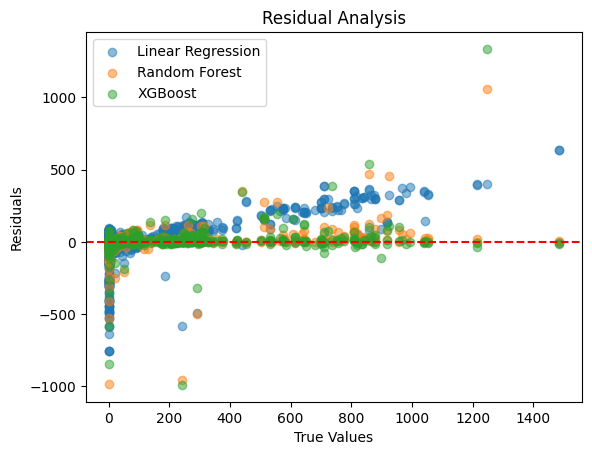

In [12]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_test - y_pred_lin, label="Linear Regression", alpha=0.5)
plt.scatter(y_test, y_test - y_pred_rf, label="Random Forest", alpha=0.5)
plt.scatter(y_test, y_test - y_pred_xgb, label="XGBoost", alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.legend()
plt.title('Residual Analysis')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.show()

### Feature Importance Visualization for Random Forest Model

This section visualizes the importance of features used in the Random Forest regression model. The steps are as follows:

1. **Extract Feature Importances**: The feature importances are obtained from the trained Random Forest model, indicating the significance of each feature in predicting the target variable.
2. **Identify Top Features**: The indices of the top 20 most important features are determined by sorting the feature importances.
3. **Bar Plot**: A horizontal bar plot is created to display the importance of the top 20 features. Each bar represents a feature's importance, with features sorted in descending order.
4. **Customization**: The y-axis is labeled with the corresponding feature names, and the plot includes labels for the x-axis and a title.

This visualization helps in understanding which features have the most influence on the model's predictions and can guide further feature selection or engineering efforts.


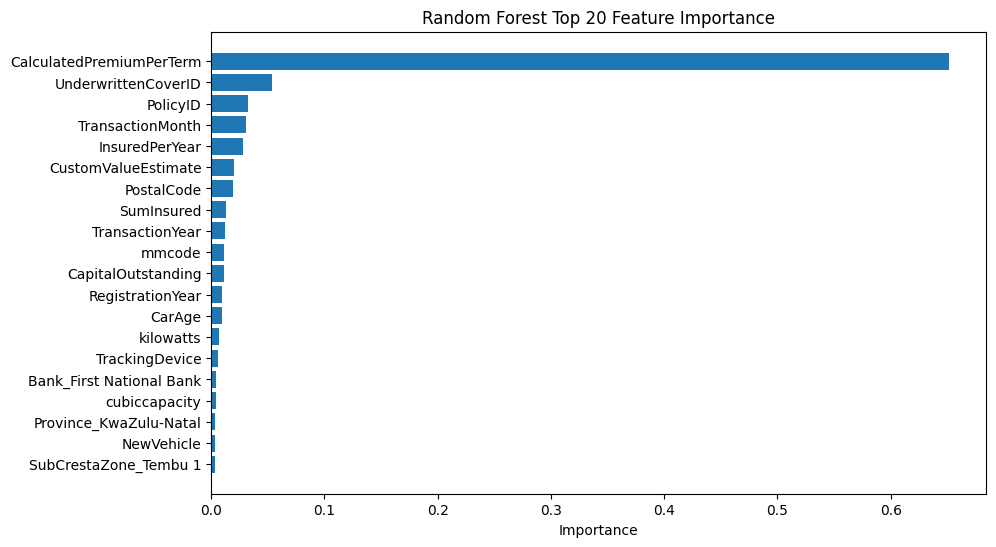

In [14]:
# Get the feature importances from the trained model
rf_importances = rf_reg.feature_importances_
# Get the indices of the top 20 important features
rf_indices = np.argsort(rf_importances)[-20:]

# Plot the top 20 important features
plt.figure(figsize=(10, 6))
plt.barh(range(len(rf_indices)), rf_importances[rf_indices], align='center')
# Use the feature names from the X_train dataframe
plt.yticks(range(len(rf_indices)), [X_train.columns[i] for i in rf_indices])
plt.xlabel('Importance')
plt.title('Random Forest Top 20 Feature Importance')
plt.show()

### Feature Importance Visualization for XGBoost Model

This section visualizes the importance of features used in the XGBoost regression model. The key steps are as follows:

1. **Extract Feature Importances**: The feature importances are retrieved from the trained XGBoost model, indicating how much each feature contributes to the model's predictions.
2. **Identify Top Features**: The indices of the top 20 most important features are obtained by sorting the feature importances in descending order.
3. **Bar Plot**: A horizontal bar plot is created to illustrate the importance of the top 20 features. Each bar corresponds to a feature's importance score, sorted from highest to lowest.
4. **Customization**: The y-axis is labeled with the names of the features, and the plot includes labels for the x-axis and a title.

This visualization provides insights into which features are most influential in the XGBoost model's predictions, assisting in understanding model behavior and guiding further analysis.


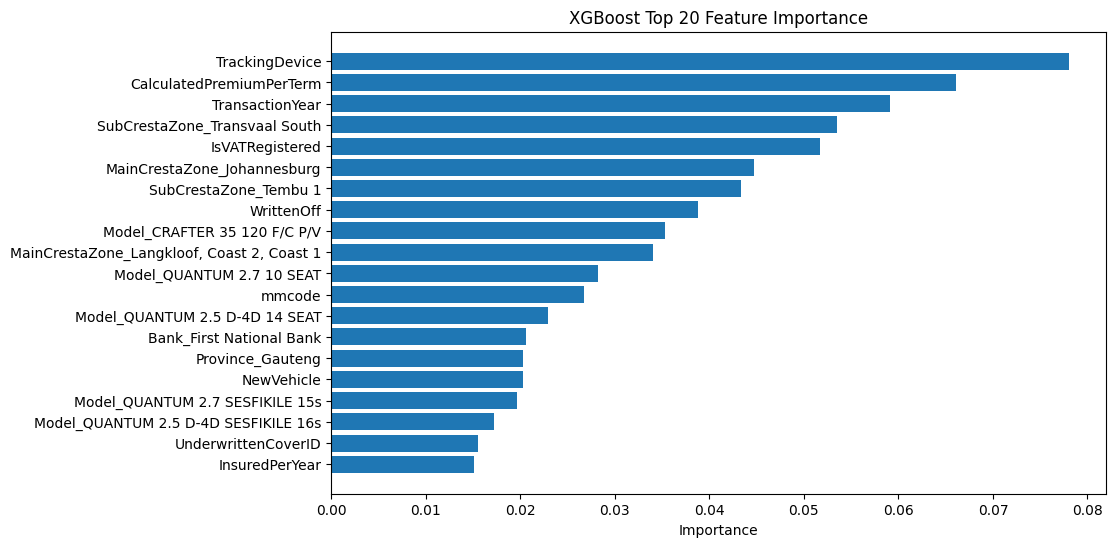

In [15]:
# XGBoost Feature Importance (assuming you have xgb_model trained)
xgb_importances = xgb_reg.feature_importances_
xgb_indices = np.argsort(xgb_importances)[-20:]  # Get indices of top 20 important features

plt.figure(figsize=(10, 6))
plt.barh(range(len(xgb_indices)), xgb_importances[xgb_indices], align='center')
plt.yticks(range(len(xgb_indices)), [X_train.columns[i] for i in xgb_indices])
plt.xlabel('Importance')
plt.title('XGBoost Top 20 Feature Importance')
plt.show()

### LIME Interpretation for Random Forest Model

This section utilizes LIME (Local Interpretable Model-agnostic Explanations) to interpret the predictions of the Random Forest regression model. The steps involved are as follows:

1. **LIME Explainer Initialization**: A LIME explainer is initialized for tabular data using the training data (X_train). This explainer is configured for regression mode.
2. **Select Instance for Explanation**: An instance from the test set is chosen for interpretation. You can modify the index `i` to explain different instances.
3. **Generate Explanation**: The `explain_instance` method is called to generate an explanation for the selected instance, using the Random Forest model's predictions. The number of features displayed in the explanation is set to 10.
4. **Visualization**: The explanation is visualized in the notebook, showing how the model's prediction is influenced by the selected features.

This interpretation aids in understanding the model's decision-making process and provides insights into which features are most impactful for individual predictions.

In [17]:
from lime import lime_tabular

In [18]:
# Initialize the LIME explainer
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    mode='regression'
)

In [30]:
# Choose an instance from the test set for explanation
i = 1  # You can change this to interpret different instances
exp = explainer.explain_instance(
    X_test.iloc[i].values,
    rf_reg.predict,
    num_features=10  # Number of features to show in the explanation
)
# Visualize the explanation
exp.show_in_notebook(show_table=True)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


### SHAP Dependence Plots for Feature Analysis

This section generates SHAP (SHapley Additive exPlanations) dependence plots for a selected list of features to analyze their impact on model predictions. The key steps are as follows:

1. **Feature Selection**: A list of features to analyze is defined, including various categorical and numerical variables related to the insurance dataset.
2. **SHAP Dependence Plots**: A loop iterates through the list of selected features, generating a SHAP dependence plot for each feature. These plots illustrate how the SHAP values (which represent the contribution of each feature to the model's predictions) vary with the feature values in the test set (X_test).

SHAP dependence plots provide insights into the relationship between the features and the model's predictions, helping to identify patterns and the significance of individual features.

In [32]:
import shap

In [33]:
# Initialize the SHAP explainer using the trained RandomForest model
explainer = shap.TreeExplainer(rf_reg)

In [34]:
# Calculate SHAP values for the test data
shap_values = explainer.shap_values(X_test)

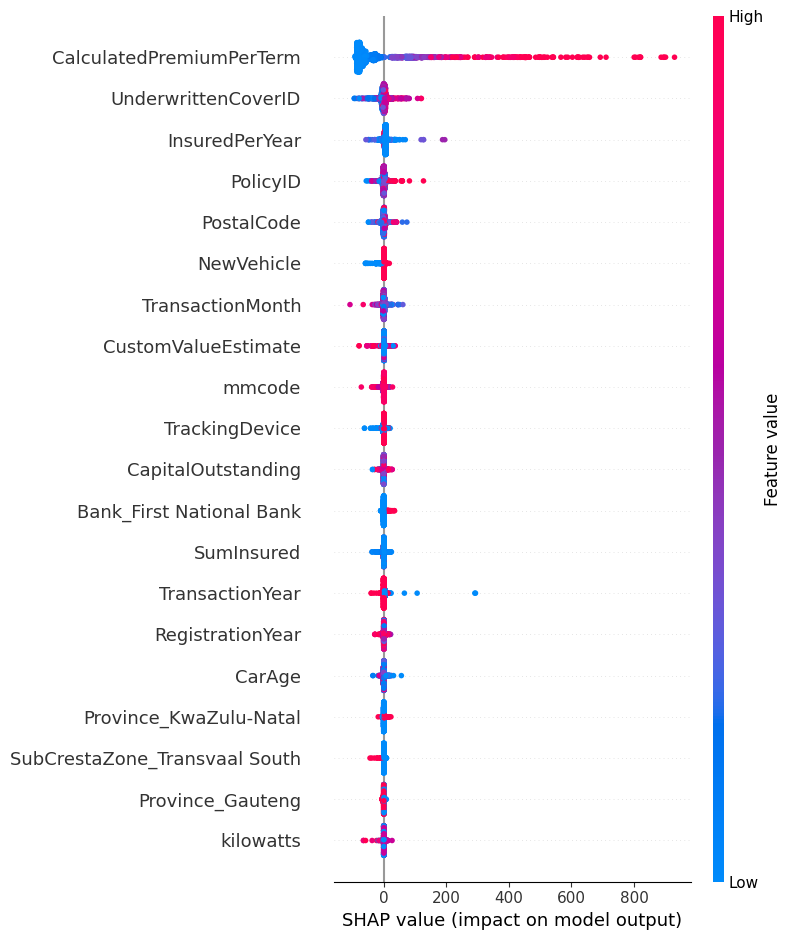

In [35]:
# Visualize the SHAP summary plot (global interpretation)
shap.summary_plot(shap_values, X_test)

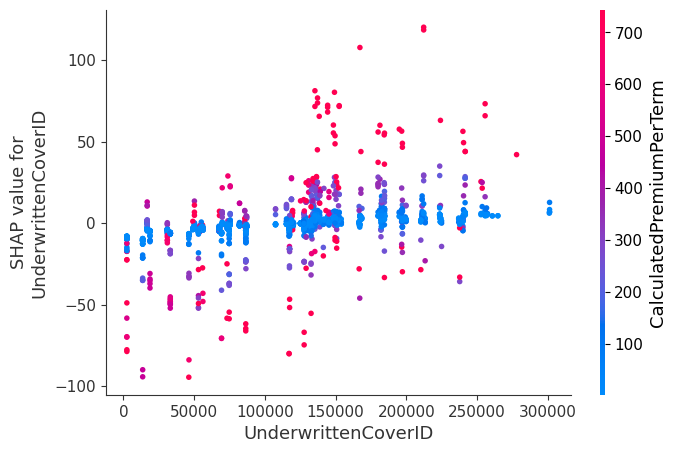

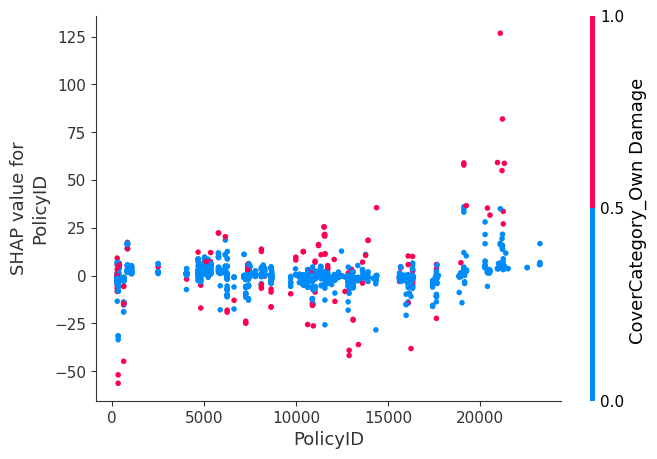

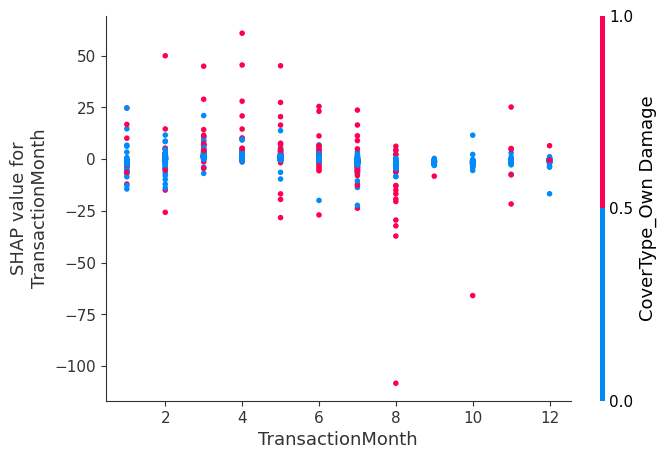

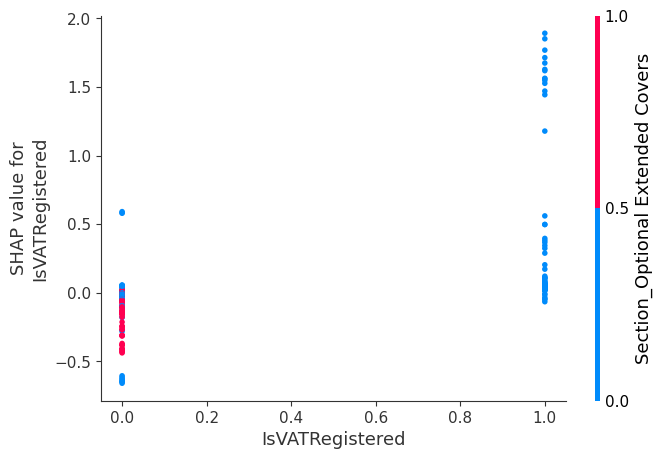

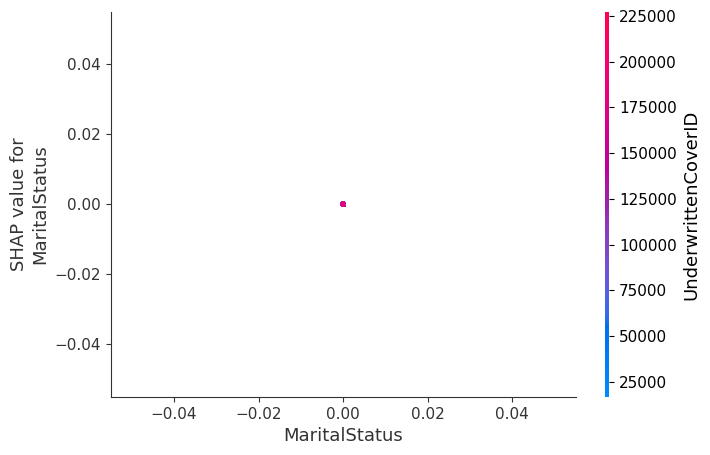

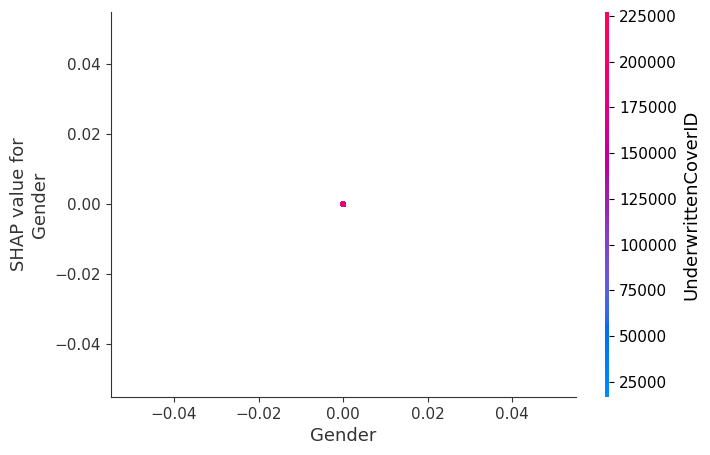

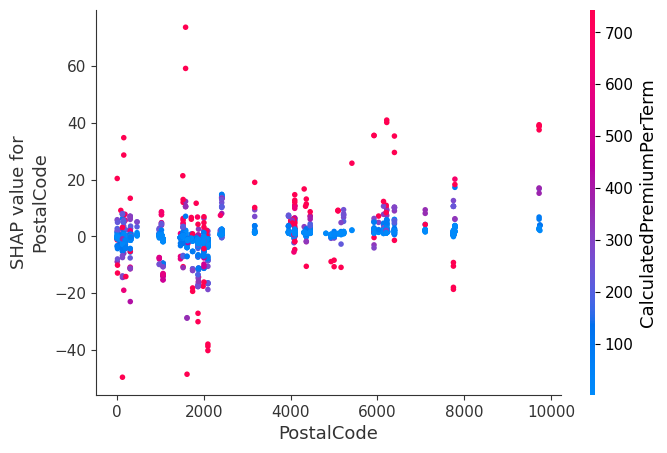

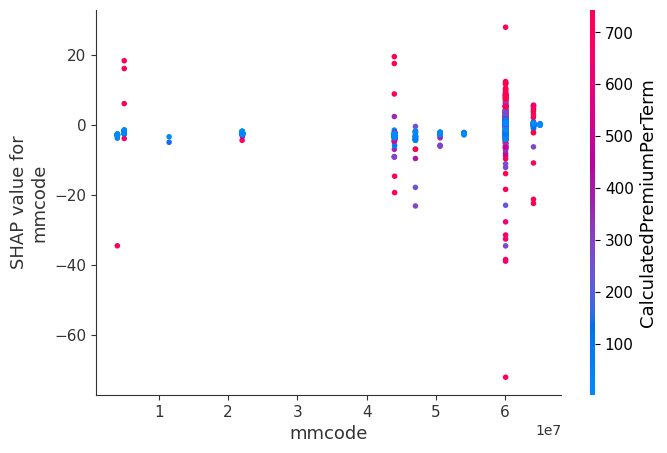

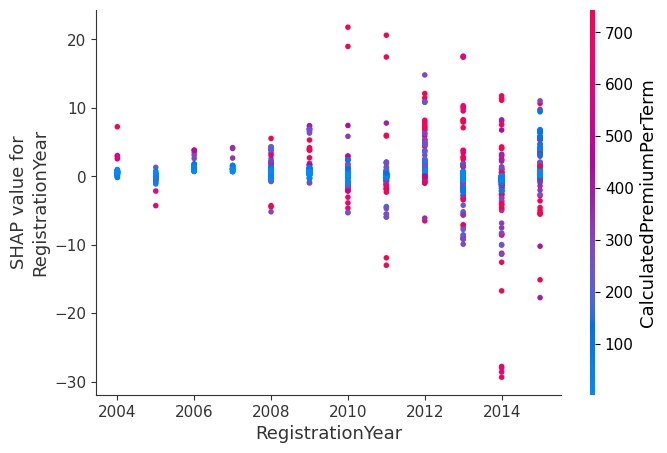

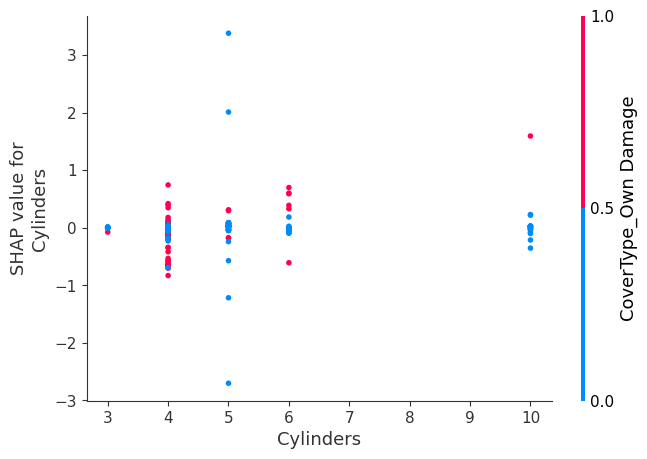

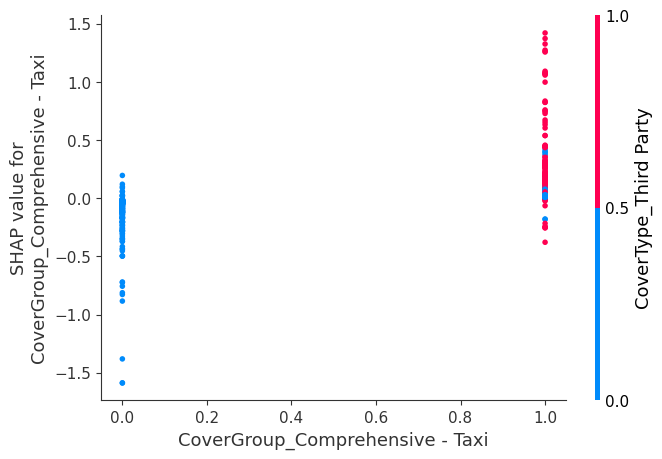

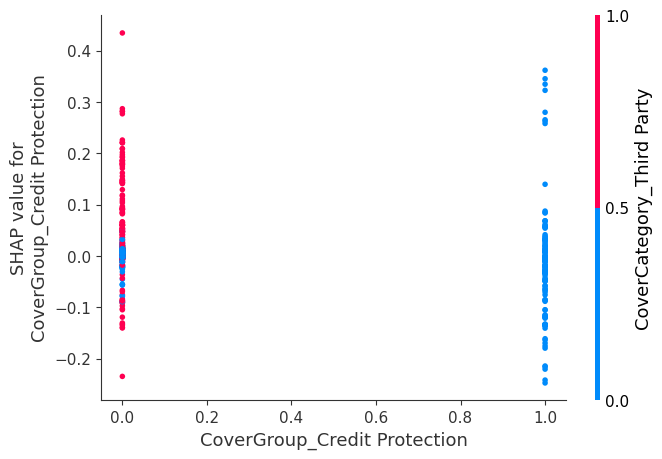

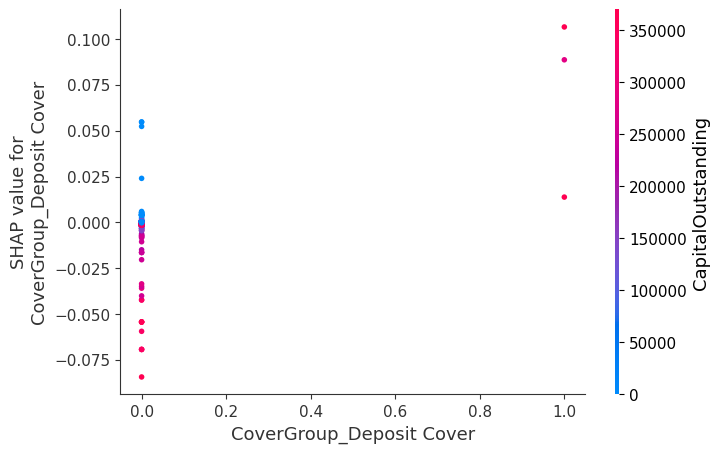

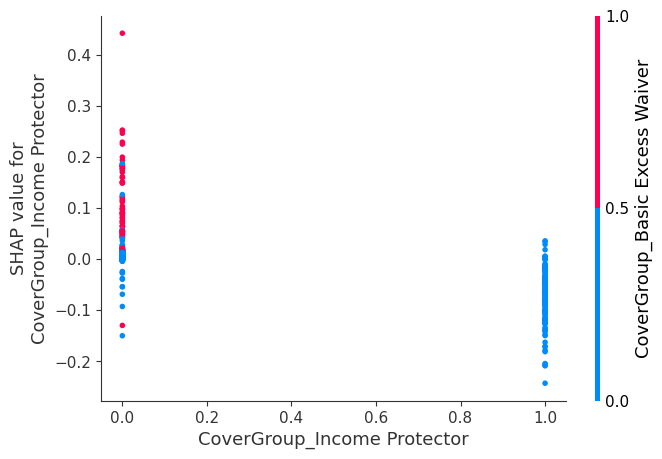

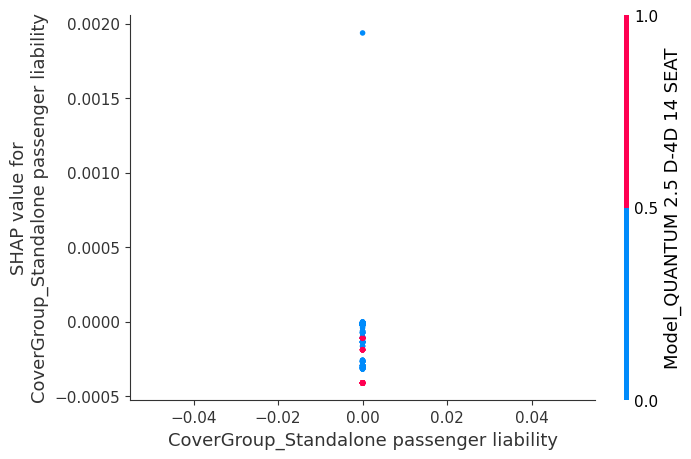

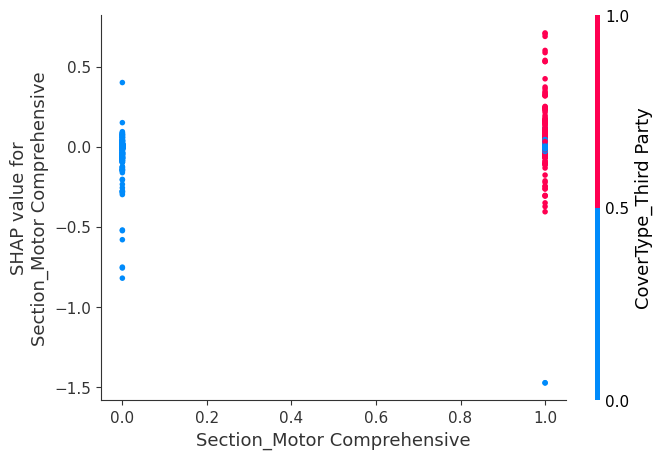

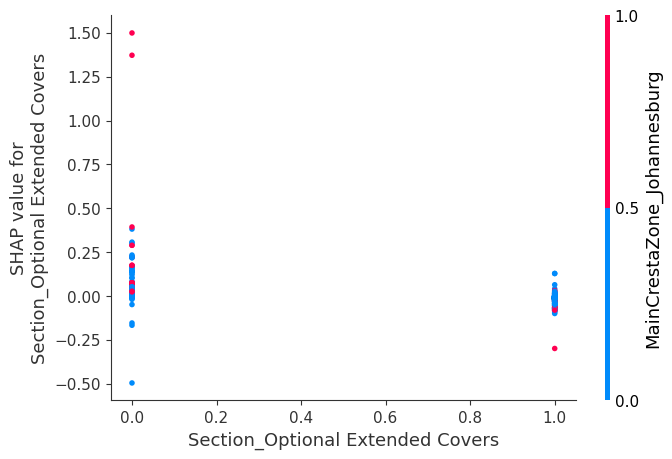

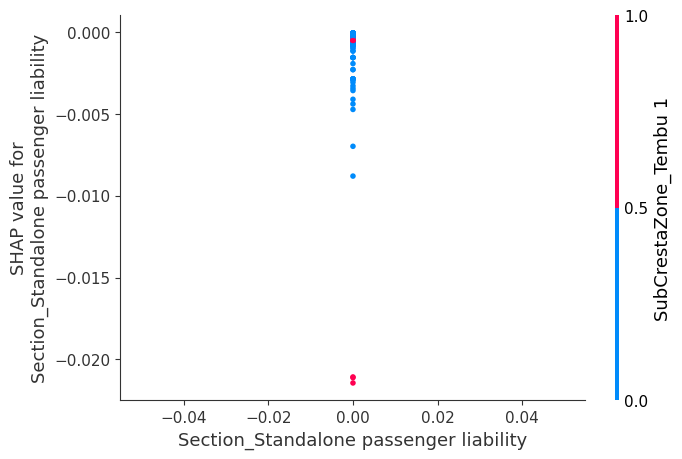

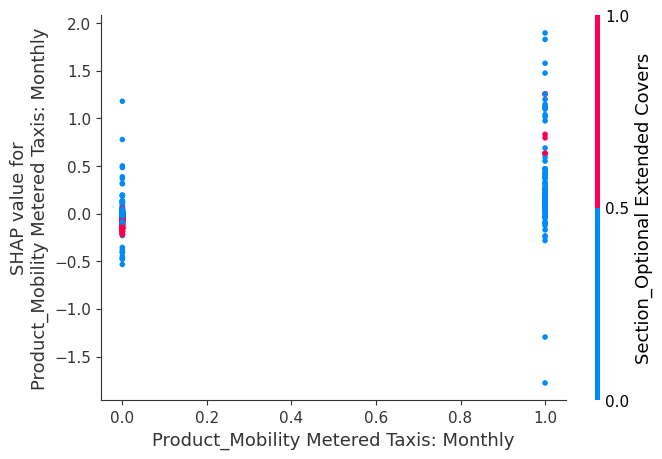

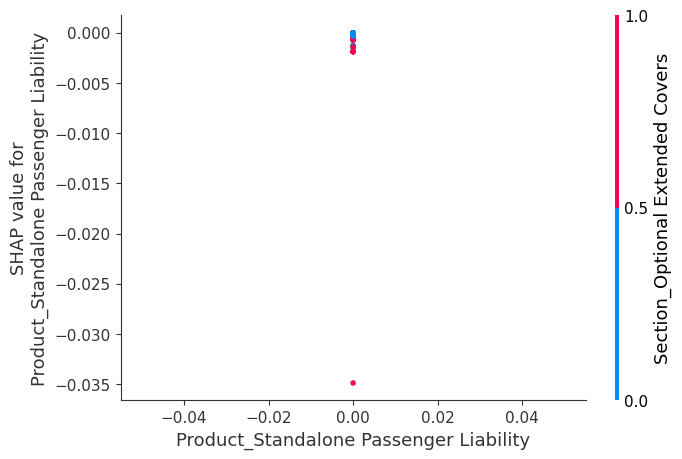

In [45]:
# List of features to analyze
features_to_analyze = [
    'UnderwrittenCoverID', 'PolicyID', 'TransactionMonth',
    'IsVATRegistered', 'MaritalStatus', 'Gender',
    'PostalCode', 'mmcode', 'RegistrationYear',
    'Cylinders',
    'CoverGroup_Comprehensive - Taxi',
    'CoverGroup_Credit Protection',
    'CoverGroup_Deposit Cover',
    'CoverGroup_Income Protector',
    'CoverGroup_Standalone passenger liability',
    'Section_Motor Comprehensive',
    'Section_Optional Extended Covers',
    'Section_Standalone passenger liability',
    'Product_Mobility Metered Taxis: Monthly',
    'Product_Standalone Passenger Liability'
]

# Generate SHAP dependence plots for each feature
for feature_name in features_to_analyze:
    shap.dependence_plot(feature_name, shap_values, X_test)